In [9]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline
from pathlib import Path

import corner
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from scipy.stats import spearmanr
import tqdm

from relaxed import plot_defaults as plotdf
from relaxed.correlations import get_am_corrs
from relaxed.correlations import get_ma_corrs
from relaxed.correlations import vol_jacknife_err
from relaxed.cosmo import get_a_from_t
from relaxed.cosmo import get_fractional_tdyn
from relaxed.cosmo import get_t_from_a
from relaxed.fits import alpha_analysis
from relaxed.fits import get_early_late
from relaxed.gradients import get_savgol_grads
from relaxed.mah import get_an_from_am
from relaxed.mah import get_mah
from relaxed.models import opcam_dict
from relaxed.models import prepare_datasets
from relaxed.models import training_suite
from relaxed.mah import get_am
import relaxed.plotting as rxplots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [10]:
params = ("cvir", "cvir_klypin", "t/|u|", "x0", "b_to_a", "c_to_a", "spin_bullock")
mah_data = get_mah("../../data/processed/bolshoi_m12", cutoff_missing=0.05, cutoff_particle=0.05)

cat = mah_data["cat"]
ma = mah_data["ma"]
am = mah_data["am"]
scales = mah_data["scales"]
mass_bins = mah_data["mass_bins"]

# prepare catalog with all a_m
am_names = [f"am_{ii}" for ii in range(len(mass_bins))]
for ii in range(len(mass_bins)):
    cat.add_column(am[:, ii], name=am_names[ii])


# load diffmah fits parameters
pars = np.load('../../data/processed/pbest_diffmah.npy')
logtc, ue, ul = pars[:, 0], pars[:, 1], pars[:, 2]
early, late = get_early_late(ue, ul)
cat.add_column(10**logtc, name="tau_c")
cat.add_column(early, name="alpha_early")
cat.add_column(late, name="alpha_late")

# add a_{1/2} also as alternative parametrization
cat.add_column(get_an_from_am(am, mass_bins, 0.5), name="a2")



In [11]:
# load diffmah fits curves.
diffmah_curves = np.load('../../data/processed/diffmah_fits.npy')
ma_diffmah_names = [f"ma_diffmah_{ii}" for ii in range(len(scales))]
for ii in range(len(scales)):
    cat.add_column(diffmah_curves[:, ii], name=ma_diffmah_names[ii])
# am_diffmah_names = [f"am_diffmah_{ii}" for ii in range(len(mass_bins))]
# am_diffmah, _ = get_am(diffmah_curves, scales, min(mass_bins), n_bins=100)
# for ii in range(len(mass_bins)):
#     cat.add_column(am_diffmah[:, ii], name=am_diffmah_names[ii])

In [12]:

info = {
    "all": {
        "x": am_names,
        "y": params,
    },
    "diffmah_curves": {
        "x": ma_diffmah_names,
        "y": params,
    },
    "diffmah_new": {
        "x": ("tau_c", "a2", "alpha_late"),
        "y": params,
    },
}
datasets, _, cat_test = prepare_datasets(cat, info)

data = {
    "multicam": {
        "xy": datasets["all"]["train"],
        "n_features": 100,
        "n_targets": len(params),
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "multicam_diffmah_curves": {
        "xy": datasets["diffmah_curves"]["train"],
        "n_features": 165,
        "n_targets": len(params),
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "multicam_diffmah_new": {
        "xy": datasets["diffmah_new"]["train"],
        "n_features": 3,
        "n_targets": len(params),
        "model": "linear",
        "kwargs": {"to_marginal_normal": True, "use_multicam": True},
    },
    "mixed_cam": {
        "xy": datasets["all"]["train"],
        "n_features": 100,
        "n_targets": len(params),
        "model": "mixed_cam",
        "kwargs": {
            "mass_bins": mass_bins,
            "opt_mbins": [opcam_dict[param]["mbin"] for param in params],
            "cam_orders": [opcam_dict[param]["order"] for param in params],
        },
    },
}
models = training_suite(data)



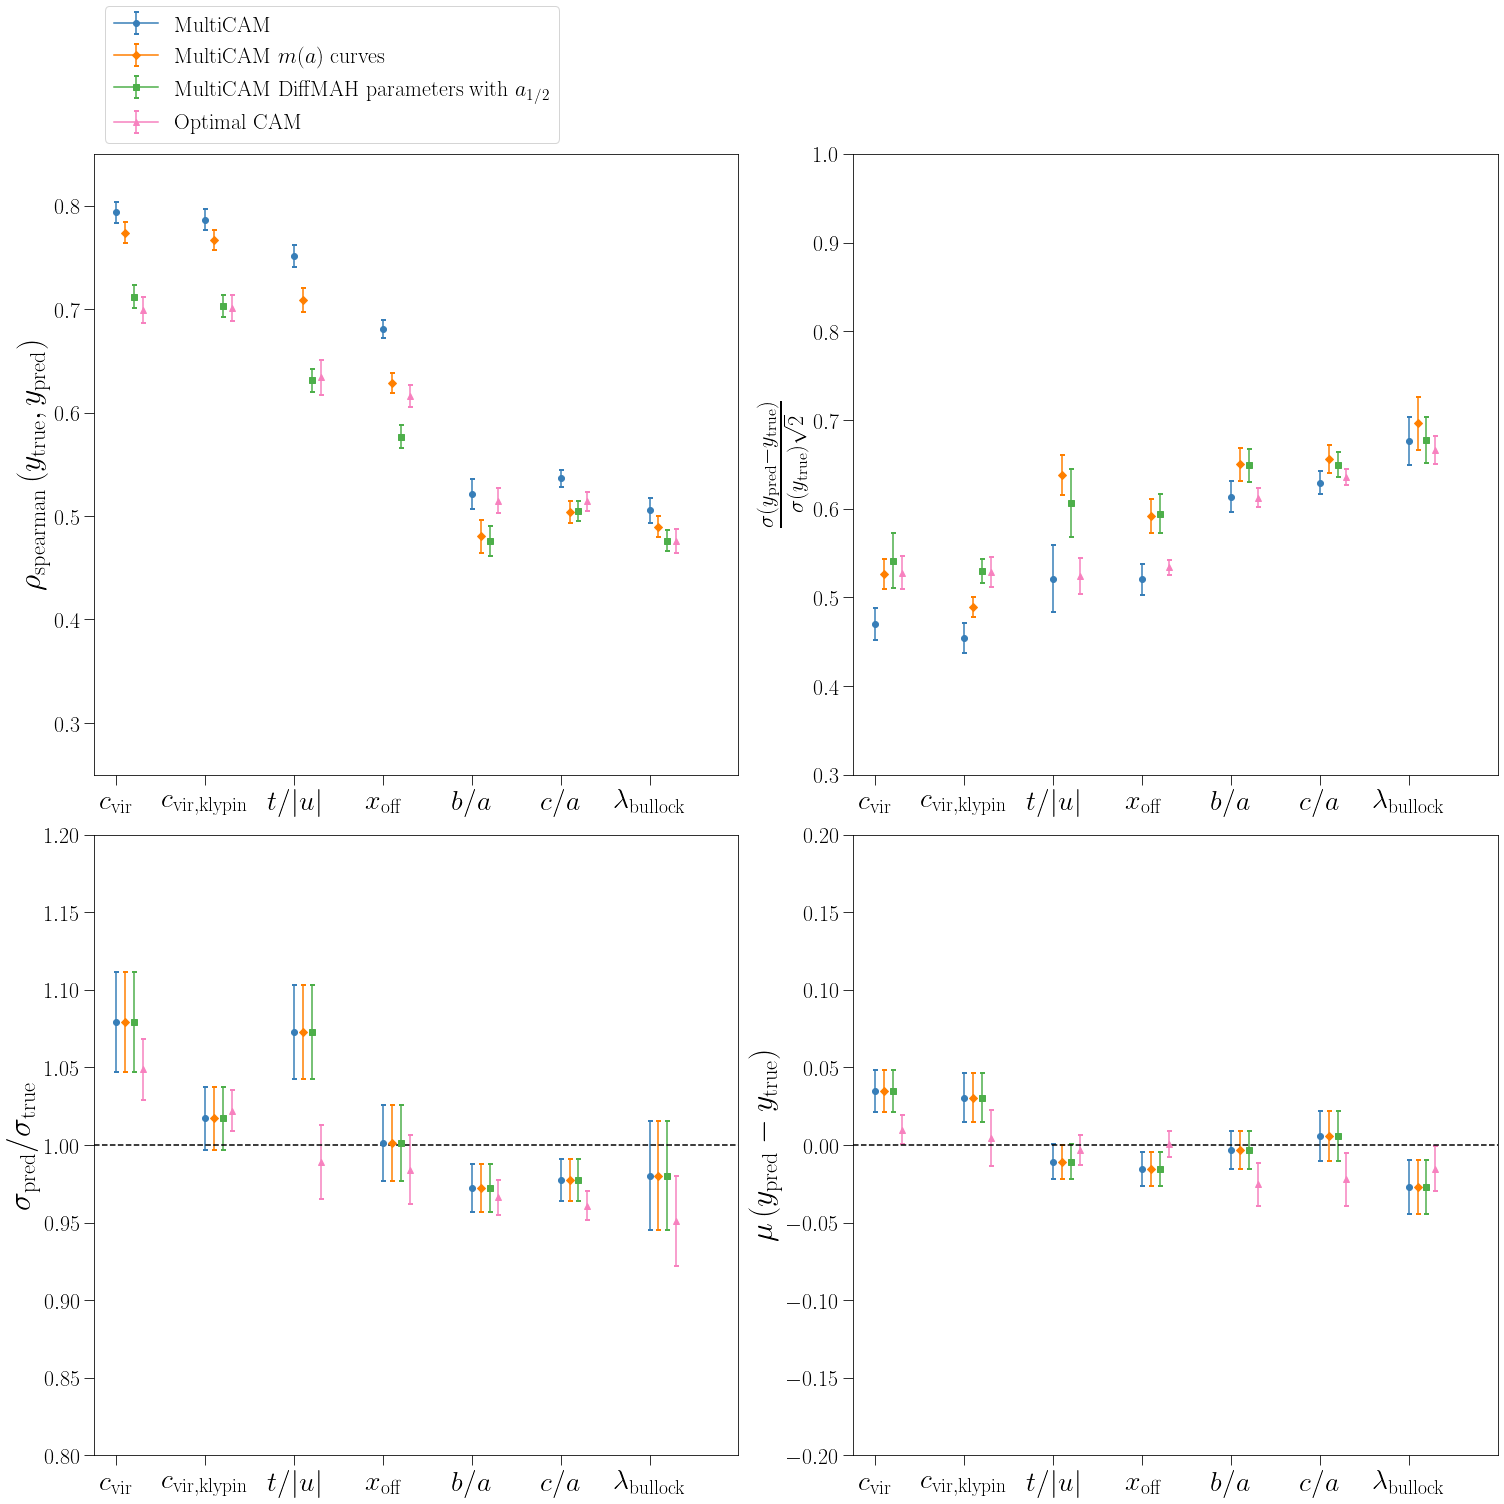

In [14]:
metrics_data = {
    "spear": {"yrange": (0.25, 0.85)},
    "rscatter": {"yrange": (0.3, 1.0)},
    "sigma_ratio": {"yrange": (0.8, 1.2), "hline": 1.0},
    "mu": {"yrange": (-0.2, 0.2), "hline": 0.0},
}

markers = ["o", "D", "s", "^"]
test_data = {
    "multicam": (datasets["all"]["test"][0], r"\rm MultiCAM", plotdf.cb_colors[0], markers[0]),
    "multicam_diffmah_curves": (
        datasets["diffmah_curves"]["test"][0],
        r"\rm MultiCAM $m(a)$ curves",
        plotdf.cb_colors[1],
        markers[1],
    ),
    "multicam_diffmah_new": (
        datasets["diffmah_new"]["test"][0],
        r"\rm MultiCAM DiffMAH parameters with $a_{1/2}$",
        plotdf.cb_colors[2],
        markers[2],
    ),
    "mixed_cam": (
        datasets["all"]["test"][0],
        r"\rm Optimal CAM",
        plotdf.cb_colors[3],
        markers[3],
    ),
}


fig = rxplots.metrics_plot(
    metrics_data,
    test_data,
    models,
    cat_test,
    params=params,
    ncols=2,
    nrows=2,
    figsize=(21, 21),
    ticksize=28,
    y_label_size=32,
    bbox_to_anchor=(0.0, 1.0, 0.45, 0.45),
)

fig.show()